# Final Project
## Pythprog.AI ITHS 2022-2023
### Local Weather Predictions

by **Rikard Lang**

## Introduction

Scouring the internet, there is an abundance of data to be found - as free and open repositories of carefully compiled information. Kaggle is one example of such a source of data. There are also other ways to find data, some websites might even share data unknowingly via an open api, but they aren't aware of it themselves. So, with access to the internet it's easy to find data. 

There are also many different problems you can solve using the above mentioned treasure troves of data. I got intrigued by weather data.

## The problem

Weather is something that we all talk about, all the time and in the realm of the meteorologists I am sure they have finely tuned models to predict the weather. More than likely, they've spent decades or more to tune these models to accurately predict the weather. Not just for the benefit of people who want to know if they should wear their boots and beanie, but for people who truly depend on accurate weather reports: mountaineers, sailors, truck drivers, explorers, pilots and so on. I want to explore how well a machine learning model can predict the weather, how accurate will it be and how fast can it deliver these predictions. 

## Accuracy versus locality 

This way of using a machine learning model will most likely not compete with the government agencies; they have lots of computer power, brain power and experience in the field. However, it could be of use when you want to predict the weather at a particular locality, one that isn't covered more than very broadly by the official predictions. An example would be that you are planning on a hike in a lesser known area, or that you are planning on finding a long chain of geocaches in particular area, combine that with the ability to gather data from local weather stations and you could predict the weather for your own needs.

## Locality

For this experiment I opted to use weather data that is somewhat local to me. Actually, the source chosen for the data passes several criteria: 
1. Geographically local data
2. Lots of measurements - hourly readings
3. A long history of readings, 79 years worth of data
4. The site of readings is located at a distance of 42 km from me, why that is important I leave as an exercise for the astute reader

So in theory this is a lot of data, over a very long timespan but will it be accurate enough?

## Potential pitfalls

Due to nature of the long timespan, this data could be of very good use to the model, it should be able to spot patterns in the vast trove of data. However, the weather has changed quite a bit over the last 79 years so the question is if the model should be trained on all of the data, or perhaps just a subset of it. We observe the weather as a cyclic and recurring event: 

1. It's winter, it gets cold
2. It's summer, it's warm and sunny (and lots of rain)
3. The observed temperature (in Sweden) on New Years Eve and Midsummers Eve are sometimes the same

So the historic data will be of use the spot these recurring temperatures, however as already mentioned - perhaps the model will do just fine with the last four months of data. This question will become more important when other people want to use a similar setup for their own needs: how much data is needed to get a somewhat accurate prediction?

Say you are looking to scale a remote mountain, not covered in detail by official weather reports, will your grandfathers four years of recorded data be enough to help you? Will three months of recorded data be of use? Can the model predict anything useful if first trained on this huge dataset and then applied with fragments of local weather data? Let's find out!

<img src="arna_airport_map.png" width=400>

## The data

### Source of data

The source of the data is https://www.smhi.se/data/meteorologi/ladda-ner-meteorologiska-observationer#param=precipitationHourlySum,stations=core,stationid=97530

This is the weather station at Ärna Airport just outside of Uppsala. This used to be, and has now reverted back to being a military airbase **F16**. I guess that being a military airbase and especially during the Cold War, is why the weather was monitored and recorded in such detail. The fighter jets did training sorties daily and the current weather was very important.

### The subdivision of data

For this project I have prepared two sets of data, all coming from the same weather station. The first file is 1944-sep-2022.csv which has all the readings from **july 1st 1944** through **september of 2022**. The other, smaller subset, as well as including more recent data is the file 220907-230115.csv: this represents, at the time of this writing, the last four months of data from the weather station. This could be substituted for fragmentary data from your own weather station. Perhaps they are the meticulate temperature recordings of your grandfather, maybe your own temperature recordings close to a mountain you will ascend during february 2023 or something similar. 

### A closer look at the data



<img src="example_of_data.png">

These are the first three lines of data. It represents the readings from the first day, **july 1st 1944**. There are four columns:

- The date

- The time in UTC

- The temperature reading with decimal point

- Quality of the data: G means the data is verified and Y means it could be an aggregated value or a hastily controlled archive data, presumably someone did a manual check on the scribblings and interpreted it as a 5.2 or 16.7

## Number of measurements

The first five years of data recording consists of three readings per day:

- 07:00
- 13:00
- 18:00

From the 1st of january 1949 there are four reading per day:

- 00:00
- 06:00
- 12:00
- 18:00

1952 they change to eight readings per day.

January 1st 1962 and onwards the temperature is recorded every hour.

# Preparing for using machine analysis

Let's prepare all the tools we will need to start making predictions

In [1188]:
import pandas as pd
import datetime
import matplotlib.pyplot as plt
import warnings
import sklearn
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import cross_val_score
import numpy
import seaborn as sns


# The obligatory sales pitch from the websites of the packages

## numpy
The fundamental package for scientific computing with Python, makes working with arrays of data a breeze. *Array-processing*

## pandas
pandas aims to be the fundamental high-level building block for doing practical, real world data analysis in Python. Additionally, it has the broader goal of becoming the most powerful and flexible open source data analysis / manipulation tool available in any language. *This is for manipulating data sets*

## scikit-learn
Simple and efficient tools for predictive data analysis. Accessible to everybody, and reusable in various contexts. *Helps out with the regression problem of predicting temperature*

Before importing the data into data frames I used Textedit.app to rename the column headers from swedish to english

# Let's load the large data set and the smaller subset into data frames

In [1189]:
large_df = pd.read_csv('./data/1944-sep-2022.csv', sep=";", low_memory=False)

In [1190]:
small_df = pd.read_csv('./data/220907-230115.csv', sep=";", low_memory=False)

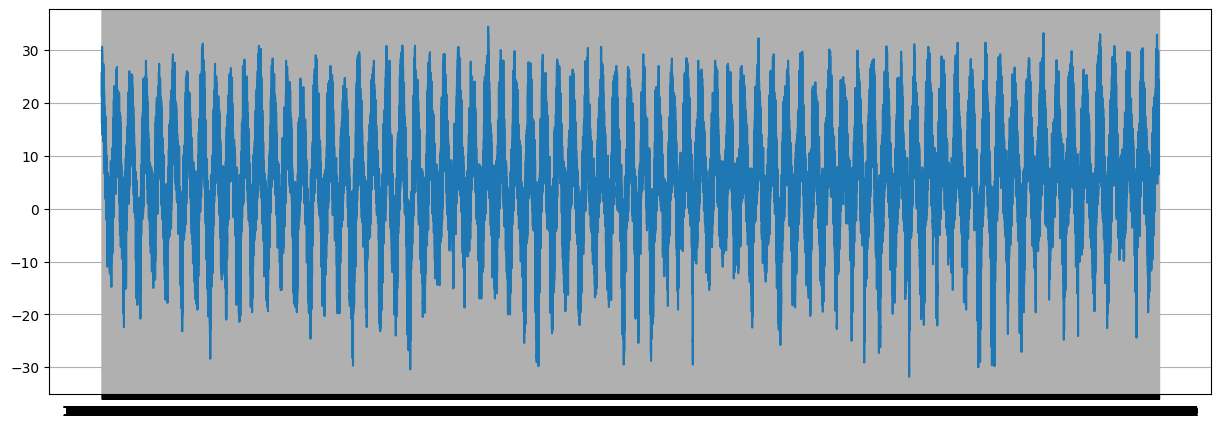

In [1191]:
plt.figure(figsize = (15,5))
fig = plt.plot(large_df['date'],large_df['temperature'])
plt.grid();

# The plot thickens
This plot took some time to complete. It looks very regular, at least from this zoomed out perspective. We'll get to that later. Micro vs. macro-levels I guess.

In [1192]:
large_df.head()

,date,time,temperature,quality,Unnamed: 4,Unnamed: 5
0,1944-07-01,07:00:00,16.2,G,NaN,NaN
1,1944-07-01,13:00:00,23.0,G,NaN,NaN
2,1944-07-01,18:00:00,20.2,G,NaN,NaN
3,1944-07-02,07:00:00,19.8,G,NaN,NaN
4,1944-07-02,13:00:00,25.8,G,NaN,NaN


In [1193]:
large_df.tail()

,date,time,temperature,quality,Unnamed: 4,Unnamed: 5
569511,2022-09-01,02:00:00,8.7,G,NaN,NaN
569512,2022-09-01,03:00:00,9.3,G,NaN,NaN
569513,2022-09-01,04:00:00,8.9,G,NaN,NaN
569514,2022-09-01,05:00:00,7.7,G,NaN,NaN
569515,2022-09-01,06:00:00,10.0,G,NaN,NaN


After loading the large dataset into a data frame and then taking the head and tail we can see that the first entry is july 1st 1944 and consists of four columns:

- Date
- Time (UTC)
- Temperature (air)
- Quality 

The last entry is for september 1st 2022.

In [1194]:
large_df.shape

(569516, 6)

*569516* rows of historical data. It's almost like being Indiana Jones and stumbling upon some old, dusty and crumpled scroll of ancient information.

In [1195]:
large_df.dtypes

date            object
time            object
temperature    float64
quality         object
Unnamed: 4     float64
Unnamed: 5     float64
dtype: object

In [1196]:
large_df.isnull().sum()

date                0
time                0
temperature         0
quality             0
Unnamed: 4     569516
Unnamed: 5     569516
dtype: int64

All values are accounted for.

In [1198]:
large_df.date.min()

'1944-07-01'

In [1199]:
large_df.date.max()

'2022-09-01'

~78 years worth of data.

In [1200]:
large_df.temperature.min()

-31.8

The coldest recorded temperature is **-31.8** and seems like a reasonable low.

In [1201]:
large_df.temperature.max()

34.4

The hottest temperature recorded is **34.4** and also seem like a reasonable high.

According to the swedish national weather service https://www.smhi.se/kunskapsbanken/meteorologi/svenska-temperaturrekord/svenska-temperaturrekord-1.5792

The highest recorded temperature in Sweden is 38 degrees celsius, that record high was recorded twice:

- Målilla, Småland in june 1947
- Ultuna, Uppland in july 1933

On the other hand, the coldest was:

- -52.6 in Vuoggatjålme in february 1966

Read more about it here: https://www.smhi.se/kunskapsbanken/meteorologi/svenska-temperaturrekord/det-svenska-koldrekordet-1.5114


# Small note about compute power

## I initially tried to run the model on the complete data set, it ran for a very long time. So I started experimenting with the smaller subset of data.

## Subset

Yes, this is the very small subset of the full dataset - it turns out that when you have a laptop, 78 years of data will take a **long time** to work through. So I opted for the smaller dataset. If you do have access to a more powerful machine, please experiment - the full dataset, with custom parameter is available at https://www.smhi.se/data/meteorologi/ladda-ner-meteorologiska-observationer#param=precipitationHourlySum,stations=core,stationid=97530


In [1202]:
small_df.head(20)

,Date,Time,Temperature,Pressure,Humidity,Precipitation
0,2022-09-07,01:00:00,4.9,1022.2,100,0.0
1,2022-09-07,02:00:00,4.7,1022.2,100,0.0
2,2022-09-07,03:00:00,4.1,1022.3,100,0.0
3,2022-09-07,04:00:00,3.7,1022.3,100,0.0
4,2022-09-07,05:00:00,4.7,1022.5,100,0.0
5,2022-09-07,06:00:00,7.5,1022.7,100,0.0
6,2022-09-07,07:00:00,11.0,1023.0,87,0.0
7,2022-09-07,08:00:00,13.7,1023.2,73,0.0
8,2022-09-07,09:00:00,13.8,1023.5,70,0.0
9,2022-09-07,10:00:00,13.7,1023.5,71,0.0


# The smaller dataset examined

This dataset contains data for the last four mounths. It contains the date in UTC-format, Time, Temperature in degrees Celsius/Centrigrade, Pressure in hektoPascal, the relative air humidity and precipitation in mm.

In [1203]:
small_df.tail(20)

,Date,Time,Temperature,Pressure,Humidity,Precipitation
3084,2023-01-14,07:00:00,3.8,994.1,100,0.0
3085,2023-01-14,08:00:00,3.6,994.7,100,0.4
3086,2023-01-14,09:00:00,3.5,995.0,100,1.0
3087,2023-01-14,10:00:00,2.4,995.3,100,0.1
3088,2023-01-14,11:00:00,2.1,995.7,100,0.0
3089,2023-01-14,12:00:00,1.8,996.4,100,0.0
3090,2023-01-14,13:00:00,1.7,997.2,100,0.0
3091,2023-01-14,14:00:00,1.2,997.6,100,0.1
3092,2023-01-14,15:00:00,0.8,997.9,100,0.3
3093,2023-01-14,16:00:00,0.7,997.8,100,0.4


# Dates

The data ranges from the dates 2022-09-07 up to 2023-01-15

In [1204]:
small_df.shape

(3104, 6)

In [1205]:
small_df.describe()

,Temperature,Pressure,Humidity,Precipitation
count,3104.000000,3104.000000,3104.000000,3104.000000
mean,3.896134,1011.548003,91.888531,0.054897
std,7.259277,10.660416,9.577431,0.322777
min,-23.100000,985.100000,50.000000,0.000000
25%,0.100000,1004.200000,88.000000,0.000000
50%,4.200000,1011.500000,95.000000,0.000000
75%,9.600000,1018.600000,99.000000,0.000000
max,18.100000,1037.200000,100.000000,10.000000


In [1206]:
small_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3104 entries, 0 to 3103
Data columns (total 6 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Date           3104 non-null   object 
 1   Time           3104 non-null   object 
 2   Temperature    3104 non-null   float64
 3   Pressure       3104 non-null   float64
 4   Humidity       3104 non-null   int64  
 5   Precipitation  3104 non-null   float64
dtypes: float64(3), int64(1), object(2)
memory usage: 145.6+ KB


In [1207]:
small_df.dtypes

Date              object
Time              object
Temperature      float64
Pressure         float64
Humidity           int64
Precipitation    float64
dtype: object

In [1208]:
small_df.corr()

/var/folders/vs/plw19_jx3311jw4q64_4tk_00000gn/T/ipykernel_16662/2970649995.py:1: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  small_df.corr()


,Temperature,Pressure,Humidity,Precipitation
Temperature,1.000000,-0.166855,-0.261177,0.030077
Pressure,-0.166855,1.000000,-0.026049,-0.111772
Humidity,-0.261177,-0.026049,1.000000,0.044544
Precipitation,0.030077,-0.111772,0.044544,1.000000


/var/folders/vs/plw19_jx3311jw4q64_4tk_00000gn/T/ipykernel_16662/2828333660.py:1: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  sns.heatmap(small_df.corr(), annot=True, fmt='.2f')


<AxesSubplot: >

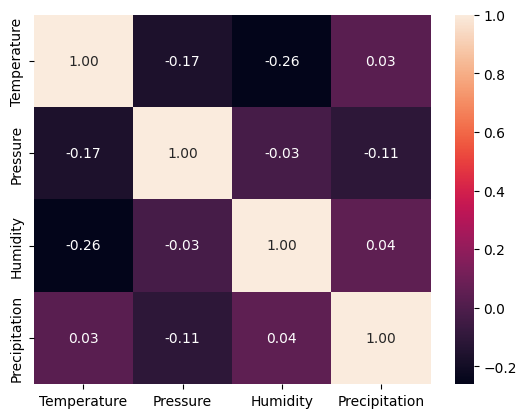

In [1209]:
sns.heatmap(small_df.corr(), annot=True, fmt='.2f')

In [1210]:
small_df.Temperature.min()

-23.1

In [1211]:
small_df.Temperature.max()

18.1

In [1212]:
small_df.Precipitation.max()

10.0

In [1213]:
small_df.Precipitation.min()

0.0

In [1214]:
small_df['Date'] = pd.to_datetime(small_df['Date'])

In [1215]:
df_pruned = small_df.resample('D', on="Date").mean()
df_pruned = small_df.dropna()
df_pruned.tail()

/var/folders/vs/plw19_jx3311jw4q64_4tk_00000gn/T/ipykernel_16662/2105722831.py:1: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  df_pruned = small_df.resample('D', on="Date").mean()


,Date,Time,Temperature,Pressure,Humidity,Precipitation
3099,2023-01-14,22:00:00,1.0,994.0,97,0.2
3100,2023-01-14,23:00:00,1.2,992.5,97,0.1
3101,2023-01-15,00:00:00,1.9,990.4,98,0.4
3102,2023-01-15,01:00:00,2.6,987.8,99,0.6
3103,2023-01-15,02:00:00,3.3,985.1,96,0.4


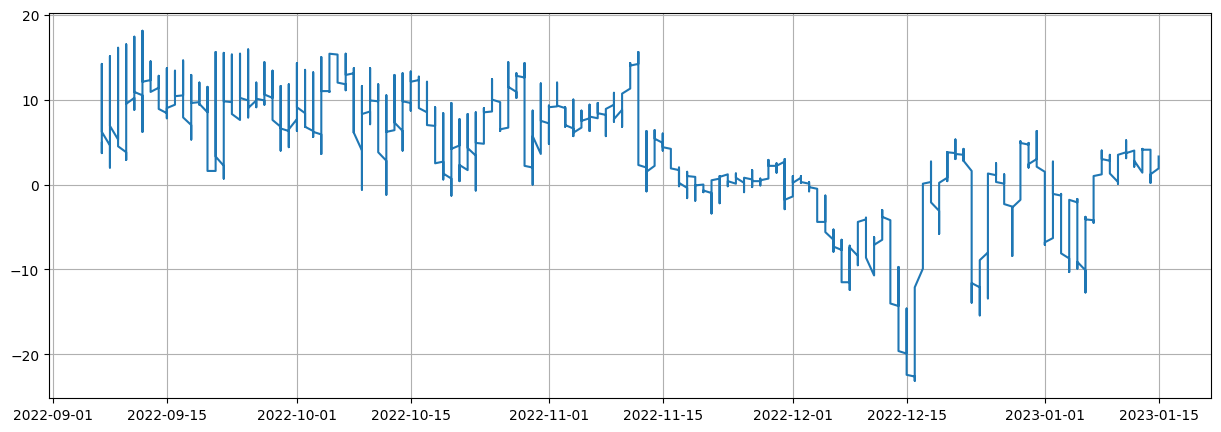

In [1216]:
plt.figure(figsize = (15,5))
fig = plt.plot(small_df['Date'],small_df['Temperature'])
plt.grid();

# Hot and cold

It was a really warm fall, quite regular until we enter december, and just past december 11th. It then plummets a lot around december 15th.

In [1218]:
small_df.dtypes

Date             datetime64[ns]
Time                     object
Temperature             float64
Pressure                float64
Humidity                  int64
Precipitation           float64
dtype: object

In [1219]:
small_df.shape

(3104, 6)

# Catwalk time

So, let's train the above data on a model and see if we can get any predictions. First let's go over the data in more detail and remove any outliers, missing data etc

In [1220]:
print(small_df.isnull().values.any())

False


In [1221]:
small_df.drop(["Date"], axis=1, inplace=True)
small_df.drop(["Time"], axis=1, inplace=True)

In [1222]:
small_df.head()

,Temperature,Pressure,Humidity,Precipitation
0,4.9,1022.2,100,0.0
1,4.7,1022.2,100,0.0
2,4.1,1022.3,100,0.0
3,3.7,1022.3,100,0.0
4,4.7,1022.5,100,0.0


# X and Y data for the model

In [1223]:
X = small_df.drop(["Temperature"], axis=1)
y = small_df["Temperature"]

In [1224]:
X.head()

,Pressure,Humidity,Precipitation
0,1022.2,100,0.0
1,1022.2,100,0.0
2,1022.3,100,0.0
3,1022.3,100,0.0
4,1022.5,100,0.0


In [1225]:
y.head()

0    4.9
1    4.7
2    4.1
3    3.7
4    4.7
Name: Temperature, dtype: float64

# Do the split

In [1226]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [1227]:
print(X_train.shape)

(2483, 3)


In [1228]:
print(X_test.shape)

(621, 3)


# What type of model do you prefer

Since this is a regression problem, there are a few models to use. If the data was very linear, a linear regression model would probably be the best fit. In this case, with weather data the data is a bit more irregular. So I went with a decision tree model. RandomForest is just a bonus thrown in for good measure

In [1229]:
tree_model = DecisionTreeRegressor()
rf_model = RandomForestRegressor()

tree_model.fit(X_train, y_train)

rf_model.fit(X_train, y_train)


RandomForestRegressor()

In [1230]:
def display_scores(scores):
    print("Scores:", scores)
    print("Mean:", scores.mean())
    print("Standard deviation:", scores.std())
    print("\n")


scores = cross_val_score(tree_model, X_train, y_train, scoring="neg_mean_squared_error", cv=10)
tree_rmse_scores = numpy.sqrt(-scores)

scores = cross_val_score(rf_model, X_train, y_train, scoring="neg_mean_squared_error", cv=10)
rf_rmse_scores = numpy.sqrt(-scores)




# How did our trained model compare to the randomforest?

In [1231]:
display_scores(tree_rmse_scores)



display_scores(rf_rmse_scores)

Scores: [9.10213657 8.29274212 7.91091347 7.51142039 8.35420776 8.56396364
 8.52853846 8.04538301 8.54459419 7.02295517]
Mean: 8.18768547586068
Standard deviation: 0.5631093228832081


Scores: [7.49847023 6.71054589 6.27040943 6.32488558 6.96197603 6.88458869
 7.09418907 6.66481472 6.83513618 6.16978716]
Mean: 6.741480298210179
Standard deviation: 0.3878702822432477




# Decision tree model
The results of the predictions from the decision tree

In [1232]:
tree_model.predict(X_test)

array([  4.        ,  -9.2       , -10.3       ,  -4.1       ,
        -5.8       ,  12.1       ,  15.1       ,  -1.4       ,
        -2.4       ,  13.8       ,  11.5       ,  -8.6       ,
         0.9       ,  10.2       ,   5.9       , -12.7       ,
         8.        ,   3.4       ,  10.9       ,   9.8       ,
         8.4       ,  15.1       ,  -7.6       ,  12.9       ,
        11.3       ,  -1.925     ,   6.8       ,  12.6       ,
         5.5       ,   6.4       ,  11.8       ,   1.45      ,
        -0.6       ,   0.6       ,  -5.2       ,  13.        ,
        -4.2       ,   1.3       ,  13.8       ,   7.8       ,
         0.8       ,   7.1       ,   3.2       ,   8.        ,
         8.7       ,   8.6       ,   2.7       ,  15.2       ,
        10.2       ,   4.8       ,   2.5       ,   8.1       ,
         1.        ,   5.5       ,   1.3       ,  10.4       ,
        11.9       ,  11.6       ,   1.65      ,   3.8       ,
        11.8       ,   8.9       ,  14.8       ,   5.46

# RandomForest 
The results from the prediction of the RandomForest model

In [1233]:
rf_model.predict(X_test)

array([ 4.23800000e+00, -5.50150000e+00, -7.06216667e+00,  1.17975000e+00,
        9.23000000e-01,  6.48669524e+00,  1.33810000e+01, -6.45500000e-01,
        6.25666667e-01,  1.36604167e+01,  9.28700000e+00,  2.78900000e+00,
        2.18646667e+00,  9.41000000e+00,  3.11600000e+00, -4.34233333e+00,
        7.41900000e+00,  2.60145238e+00,  5.30033333e+00,  6.62400000e+00,
       -5.35000000e-01,  1.05780000e+01, -4.27000000e+00,  1.17410000e+01,
       -3.31500000e+00, -1.92870317e+00,  1.74021667e+00,  1.20860000e+01,
        5.32349524e+00,  6.63250000e+00,  3.34533333e+00,  1.49757222e+00,
        2.99383333e+00,  2.21466667e-01, -1.36031429e+00,  4.78525000e+00,
       -2.85483333e+00,  6.15333333e-01, -7.75316667e+00,  8.74700000e+00,
        6.56333333e-01, -3.60000000e-02,  3.18748730e+00,  6.80313333e+00,
        8.42700000e+00,  8.18520000e+00,  2.72083333e+00,  1.09350000e+01,
        9.00550000e+00,  5.35400000e+00,  2.30025000e+00,  4.93631667e+00,
        4.05500000e+00,  

# Actual values

In [1234]:
y_test.head(20)

1653     5.0
2188   -11.5
309     10.4
746      6.8
1097     8.5
903     12.8
2375   -19.5
554      6.0
1034     1.8
736     13.1
1195    13.9
321      2.0
1618     4.0
432     11.0
2606    -7.8
443      9.5
17      11.4
1992     2.0
2355   -18.1
1553    14.3
Name: Temperature, dtype: float64

# Conclusion


## The data

Gathering the data was the easiest step. I was lucky that SMHI has such a great open API service, the problem was finding a good model to handle the data. As it turns out, the weather data has a lot of fluctations, so it will be hard to model this kind of behavior. I guess this is why we still have SHMI and similar weather agencies. Now, could this be used for what I said in the beginning? Yes, if you lack a proper weather report concering some locale, you can probably use this as a stepping stone to create something even better.

## Pre-processing

Well, this was all done by hand. But, there are of course better options available, AWS have a few automatic tools available that will help you pre-process the data and even suggest suitable models for you to use.

## Visualization

Python has access to many good options for plotting data in various forms and manners. As humans, we have a hard time making sense of numbers in isolation, but plotted over time for example it's easier for us to interpret it in a meaningful way.

## The model

This took some research and quite a few hours of scouring the internet for clues. It seems that most weather predictions are toy-like implementations, much like my own. There is a reason that weather agencies use custom and very specific models when trying to make forecasts.

## Usage of ML for local weather predictions

My advice would be to train the model on as much data, as close to you as possible. After that experiment with your local weather data and see if the predicted data makes sense.

## Areas left for future improvements

Gathering the weather data from the SHMI API automatically, perhaps based on the users coordinates. Do further research and see if there are any fully trained models on weather data already - that is, pickled models ready to use. 